# Introduction to TimeSeries data

TimeSeries data has very distinct features

- Temporal component. Basic assumptions of independent data points don’t hold true
- Trend: Deterministic or Stochastic
- Seasonality: pattern that reflects periodicity or fluctuations


#### Additional TimeSeries Datasets
https://machinelearningmastery.com/time-series-datasets-for-machine-learning/

            #Passengers
Month                  
1949-01-01          112
1949-02-01          118
1949-03-01          132
1949-04-01          129
1949-05-01          121


/opt/dev/environments/project_env.ml/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


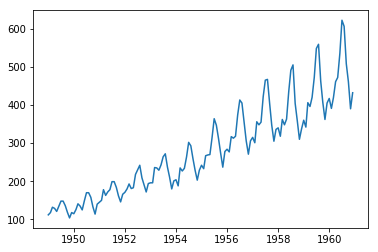

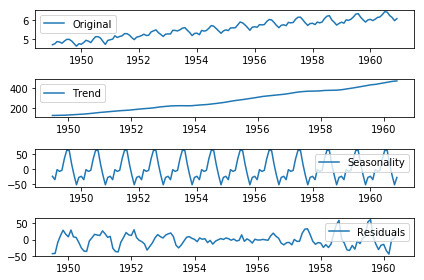

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
data = pd.read_csv('data/AirPassengers.csv', parse_dates=['Month'], index_col='Month',date_parser=dateparse)
print(data.head())

ts = data['#Passengers'] 
plt.plot(ts)
plt.show()
ts_log = np.log(ts)

from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

plt.show()

### Spot checking if TS is Stationary with Moving Average

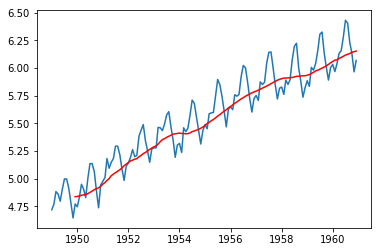

In [2]:
# moving average
moving_avg = ts_log.rolling(window=12, center=False).mean()
rolstd = ts_log.rolling(window=12, center=False).std()

plt.plot(ts_log)
plt.plot(moving_avg, color='red')
#plt.plot(rolstd, color='black', label= Rolling Std')
#plt.legend(loc='best')
plt.show()

### Lets explore differencing the series to make it stationary

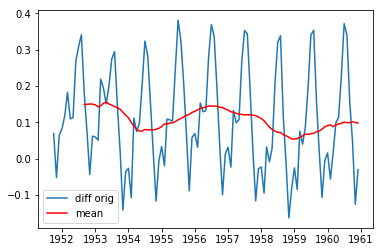

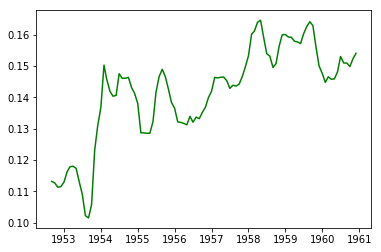

In [5]:
# Subtract rolling mean

ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.dropna(inplace=True)

moving_avg = ts_log_moving_avg_diff.rolling(window=12, center=False).mean()
rolstd = ts_log_moving_avg_diff.rolling(window=12, center=False).std()

plt.plot(ts_log_moving_avg_diff, label="diff orig")
plt.plot(moving_avg, color='red', label='mean')
plt.legend(loc='best')
plt.show()
plt.plot(rolstd, color='green', label='???')
plt.show()

### EXPONENTIAL SMOOTHING

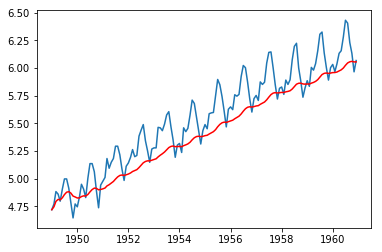

In [7]:
expwighted_avg = ts_log.ewm(halflife=12,ignore_na=False,min_periods=0,adjust=True).mean()
plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')

### Stationary Test with Dickey-Fuller

In [65]:
from statsmodels.tsa.stattools import adfuller

dftest = adfuller(ts_log, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Test Statistic                  -1.717017
p-value                          0.422367
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (5%)             -2.884042
Critical Value (1%)             -3.481682
Critical Value (10%)            -2.578770
dtype: float64


** Test static value > 1%,5%,10%, hence series is not stationary **


### Switching Gears -- ARIMA Forecasting

Lets now work with a simple shampoo sales dataset
https://datamarket.com/data/set/22r0/sales-of-shampoo-over-a-three-year-period

predicted=391.723518, expected=440.400000
predicted=353.007360, expected=315.900000
predicted=385.696669, expected=439.300000
predicted=367.847688, expected=401.300000
predicted=448.605023, expected=437.400000
predicted=401.917993, expected=575.500000
predicted=429.887225, expected=407.600000
predicted=514.777969, expected=682.000000
predicted=442.026590, expected=475.300000
predicted=651.955289, expected=581.300000
predicted=561.306328, expected=646.900000
Test MSE: 7261.863


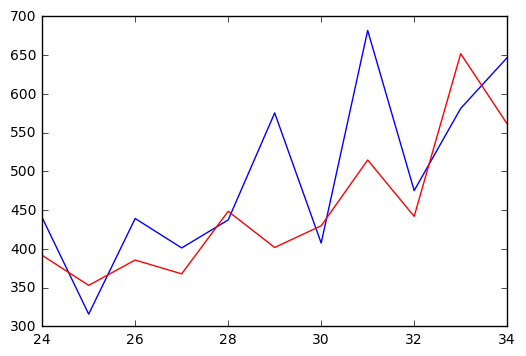

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

series = pd.read_csv('data/shampoo-sales.csv', header=0, index_col=0, squeeze=True)

X = series.values
ticks = range(len(X))

size = int(len(X) * 0.7)
train, test = X[0:size], X[size:len(X)]
history = [float(x) for x in train[:size]]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

# plot
plt.plot(ticks[-len(test):], test)
plt.plot(ticks[-len(test):], predictions, color='red')
plt.show()

### TimeSeries with LSTM 
<-- for detailed instructions, look at the univariate time series notebook

In [ ]:
# Tx = Tx-1, Tx-2 ; Window size = 2
import mxnet as mx
import numpy as np

dataset = series.values
ticks = range(len(dataset))

from sklearn.preprocessing import MinMaxScaler

dataset = np.reshape(dataset, (len(dataset), 1))
scaler = MinMaxScaler(feature_range=(0,1))
scaled_dataset = scaler.fit_transform(dataset)

dataset[:5],  scaled_dataset[:5]

# align the data

seq_len = 2

x = scaled_dataset
y = scaled_dataset[: ,[-1]]

x[:5], y[:5]

dataX = []; dataY = []

for i in range(0, len(y)-seq_len):
    _x = x[i: i+seq_len]
    _y = y[i+seq_len]
    dataX.append(_x)
    dataY.append(_y)
    
dataX[0], dataY[0]

# Tx0, Tx1 => Tx2 
# Tx1, Tx2 => Tx3

# Define Itertors 

#split the data
train_size = int(len(dataY) * 0.7)
test_size = len(dataY) -  train_size

batch_size = 8

trainX, testX = np.array(dataX[:train_size]), np.array(dataX[train_size:])
trainY, testY = np.array(dataY[:train_size]), np.array(dataY[train_size:])


train_iter = mx.io.NDArrayIter(data=trainX, label=trainY, 
                               batch_size=batch_size, shuffle=True)

val_iter = mx.io.NDArrayIter(data=testX, label=testY, 
                               batch_size=batch_size, shuffle=False)

trainX.shape


# Lets build the network
data = mx.sym.var("data")
data = mx.sym.transpose(data, axes=(1,0,2))

# T N C -- Time Steps/ Seq len; N - Batch Size, C - dimensions in the hidden state

'''
Long-Short Term Memory (LSTM) network cell.

Parameters:	
num_hidden (int) – Number of units in output symbol.
prefix (str, default ‘lstm_‘) – Prefix for name of layers (and name of weight if params is None).
params (RNNParams, default None) – Container for weight sharing between cells. Created if None.
forget_bias (bias added to forget gate, default 1.0.) – Jozefowicz et al. 2015 recommends setting this to 1.0

'''

lstm1 = mx.rnn.LSTMCell(num_hidden=5, prefix='lstm1')
lstm2 = mx.rnn.LSTMCell(num_hidden=10, prefix='lstm2')

L1, states = lstm1.unroll(length=seq_len, inputs=data, merge_outputs=True, layout="TNC")
L2, L2_states = lstm2.unroll(length=seq_len, inputs=L1, merge_outputs=True, layout="TNC")

L2_reshape = mx.sym.reshape(L2_states[0], shape=(-1, 0), reverse=True)  # (T*N, 10 -- num_hidden lstm2)
fc = mx.sym.FullyConnected(L2_reshape, num_hidden=1, name='fc')
net = mx.sym.LinearRegressionOutput(data=fc, name="softmax")

#mx.viz.plot_network(net) #, shape=(1,2,2))

import logging
logging.getLogger().setLevel(logging.DEBUG)

num_epochs = 250
model = mx.mod.Module(symbol=net, context=mx.cpu(0))

model.fit(train_data=train_iter, eval_data=val_iter,
        optimizer="adam",
        optimizer_params={'learning_rate': 1E-3},
        eval_metric="mse",
        num_epoch=num_epochs
         )


``` After 250 epochs
INFO:root:Epoch[249] Time cost=0.013
INFO:root:Epoch[249] Validation-mse=0.022094
```

0.0244589624935
[[ 378.33590698]
 [ 419.44488525]
 [ 360.60461426]
 [ 440.92233276]
 [ 422.61529541]] [[ 0.34938688]
 [ 0.56868669]
 [ 0.50115514]
 [ 0.56531011]
 [ 0.81073396]]


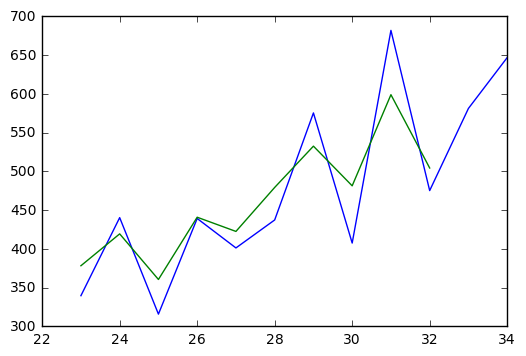

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

test_pred = model.predict(val_iter).asnumpy()
print(np.mean((test_pred - testY)**2))

test_plot = scaler.inverse_transform(test_pred)
print(test_plot[:5], testY[:5])

#plt.plot(ticks[train_size+seq_len:], test_plot)

t_plot = np.empty_like(dataset)
t_plot[:] = np.nan
t_plot[len(trainY): -seq_len] = test_plot 
#plt.plot(ticks, dataset, label="real data")
plt.plot(ticks[len(trainX):], dataset[len(trainX):], label="real data") #only test data
plt.plot(ticks, t_plot, label= "pred")
#plt.legend()

##### References
https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/